In [1]:
import ctypes
from ctypes import c_char_p
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import random


In [2]:
# @numba.jit(nopython=True)
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # img = Image.open(img_path).convert('L')  # Conversion en gris
        img = Image.open(img_path).convert('RGB')
        img = img.resize((32, 32))  # Resize les images
        img_array = np.array(img, dtype=np.float64).flatten()  # Flatten les vecteurs
        images.append(img_array)
        labels.append(label)
    return images, labels

folder_a = 'data/dataset/resized/gas_giant'
folder_b = 'data/dataset/resized/neptune-like'
folder_c = 'data/dataset/resized/super_earth'

images_a, labels_a = load_images_from_folder(folder_a, [1.0, 0.0, 0.0])
images_b, labels_b = load_images_from_folder(folder_b, [0.0, 1.0, 0.0])
images_c, labels_c = load_images_from_folder(folder_c, [0.0, 0.0, 1.0])

X = np.array(images_a + images_b + images_c)
y = np.array(labels_a + labels_b + labels_c)



In [3]:
# Séparer les données entrainement / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=None)

print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [4]:
def display_selected_images(images, labels, indices, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(indices):
            index = indices[i]
            # image_2d = images[index].reshape((64, 64)) 
            image_3d = images[index].reshape((32, 32, 3)) 
            if image_3d.max() > 1.0:
                image_3d = image_3d / 255.0 
            # ax.imshow(image_2d, cmap='gray')
            ax.imshow(image_3d)
            ax.set_title(f"Label: {labels[index]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

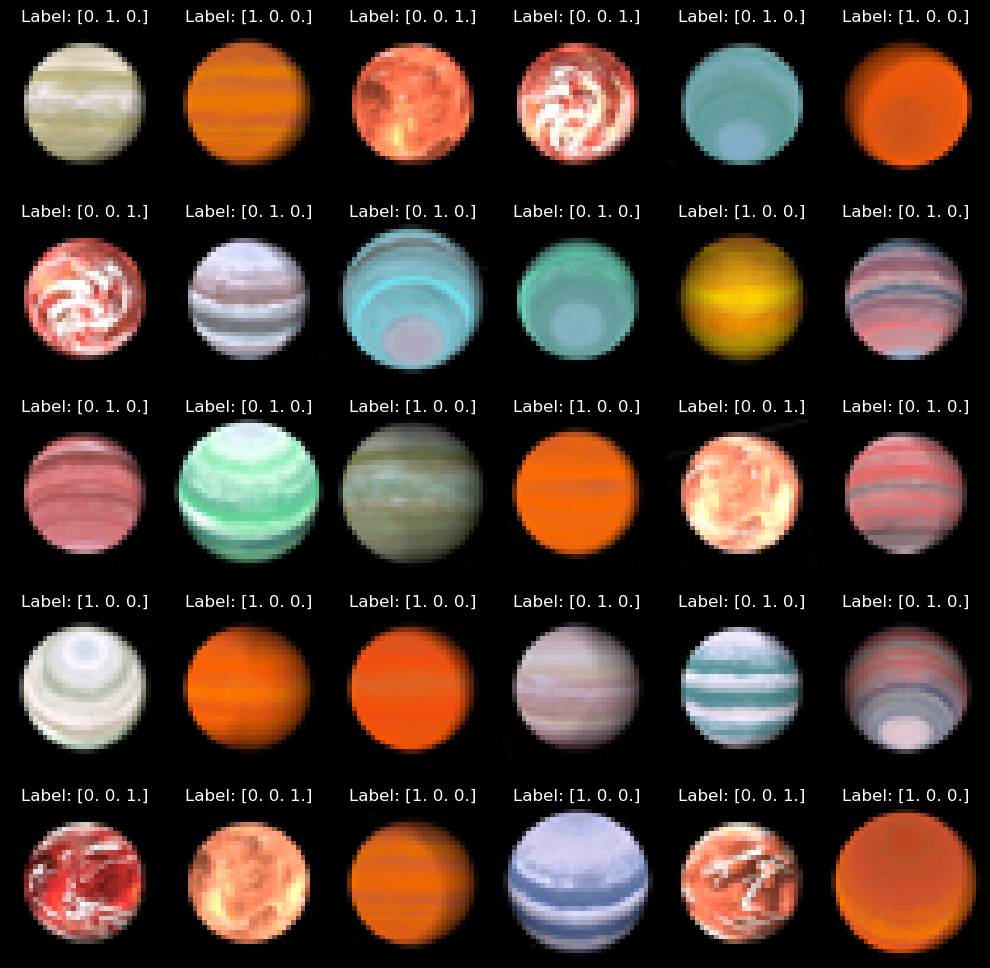

In [5]:
# selected_indices = [1, 2, 3, 4, 5, 6]
# nrows, ncols = 5, 10

nrows, ncols = 5, 6
max_images = nrows * ncols
total_images = X_train.shape[0]

# random
selected_indices = random.sample(range(total_images), min(max_images, total_images))


# à partir d'un point de départ
# start_index = 30
# selected_indices = list(range(start_index, start_index + max_images))
# selected_indices = [i for i in selected_indices if i < len(X_train)]



display_selected_images(X_train, y_train, selected_indices, nrows, ncols)

In [6]:
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

print(X_train[5])
print(X_test[:5])

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
print("-----------------")
print(X_train[5])
print(X_test[:5])

[0. 0. 0. ... 0. 0. 0.]
[[ 1.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... 25. 25. 25.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
-----------------
[-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
 -0.89741556]
[[-0.88541752 -0.88541752 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.59746455 -0.59746455
  -0.59746455]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]]


# Perceptron multi couche

In [7]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_char_p  
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


In [8]:
print(f"vecteur : {X_train}")
print(f"type : {type(X_train[0][0])}")
print(f"pointer : {X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))}")
print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

vecteur : [[-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 ...
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]
 [-0.89741556 -0.89741556 -0.89741556 ... -0.89741556 -0.89741556
  -0.89741556]]
type : <class 'numpy.float64'>
pointer : <__main__.LP_c_double object at 0x7f3c2b16dad0>
Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [9]:
neurons_size = np.array([X_train.shape[1], 32, 16, 3], dtype=np.uintp)
learning_rate = 0.00001
epochs = 1000
callback_interval = 100
checkpoint_enable = False
checkpoint_interval = 10000
log_enable = True
log_tag = "exoplanet".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

layer : 3
neural matrix : [NeuralMatrix { matrix: [[-0.9385302942953513, -0.21997686406825911, 0.49550111557363463, -0.7880473314163496, 0.49760550171430973, 0.2367637086448533, -0.5840544240444094, 0.7709099419227918, 0.647191345248217, -0.7993890229191214, -0.434625100893272, -0.047609986558586836, 0.2612493219451655, -0.5480398571704659, 0.17396376365079202, 0.7393034570670811, -0.9549222070512684, -0.9826684261612191, -0.8563447723727147, 0.15906319615275422, -0.9977594073312077, 0.6187232673768865, 0.317327582718796, 0.8790747559384284, 0.7618910578248572, 0.5561100074739196, 0.5221514277444586, 0.12186715708135942, 0.18956315427131143, 0.664779294202372, 0.18652496401929586, 0.7243792396499091, 0.5818415099652463, 0.5221622513302058, 0.6973731390223596, 0.6605702770160051, 0.9583592509945253, 0.18177551557469096, -0.3114558899872475, 0.5925985540864502, -0.6842168471833254, -0.6186869686862027, -0.38371846463350767, 0.38697089678599594, 0.24078054521356318, -0.7788027519054581, -

In [10]:
progress_bar = tqdm(total=epochs, desc="Training Progress")
losses = []
def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)
    losses.append(loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

trainResult = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    1,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
predictions_list_train = []
labels_list_train = []
predictions_list = []
labels_list = []

for k in range(len(X_train)):
    predictions = np.zeros(y_train.shape[1], dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions_list_train.append(predictions)
    labels_list_train.append(y_train[k])

for k in range(len(X_test)):
    predictions = np.zeros(y_train.shape[1], dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_test[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_test[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions_list.append(predictions)
    labels_list.append(y_test[k])

In [12]:
predictions_array_train = np.array(predictions_list_train)
labels_array_train = np.array(labels_list_train)

# for i in range(10):
#     print(f"Sample {i}, True Label: {labels_array[i]}, Predictions: {predictions_array[i]}")

accuracy = np.mean(np.argmax(predictions_array_train, axis=1) == np.argmax(labels_array_train, axis=1))
print(f"Accuracy train data: {accuracy * 100:.2f}%")

Accuracy train data: 54.42%


In [13]:
predictions_array = np.array(predictions_list)
labels_array = np.array(labels_list)

# for i in range(10):
#     print(f"Sample {i}, True Label: {labels_array[i]}, Predictions: {predictions_array[i]}")

accuracy = np.mean(np.argmax(predictions_array, axis=1) == np.argmax(labels_array, axis=1))
print(f"Accuracy test data: {accuracy * 100:.2f}%")

Accuracy test data: 55.33%


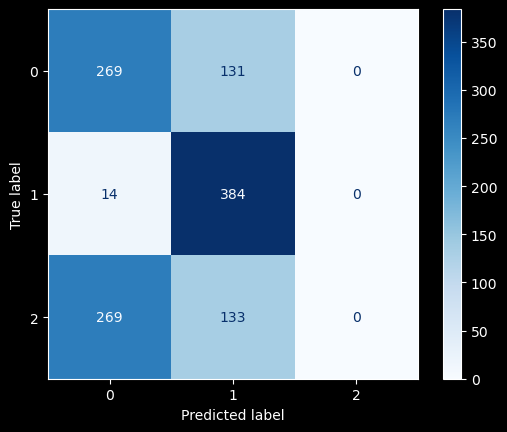

In [14]:
cm = confusion_matrix(np.argmax(labels_array_train, axis=1), np.argmax(predictions_array_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

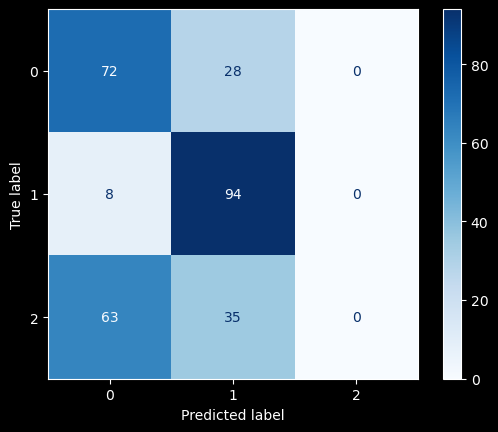

In [15]:

cm = confusion_matrix(np.argmax(labels_array, axis=1), np.argmax(predictions_array, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
mlp_model.mlpFree(nn)